In [1]:
import itertools
# 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
# 
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
# parameters
num_class = 5
split_date = '2023-04-01'
random_state=42
start_date = '2007-01-01'
end_date = '2024-05-01'

In [4]:
# daily data download
df = yf.download('^NDX', start=start_date, end=end_date)
df.drop(columns=['Volume','Adj Close'], inplace=True)
df.sort_values(by=['Date'],inplace=True)
df.reset_index(inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close
0,2007-01-03,1769.219971,1793.050049,1731.709961,1759.369995
1,2007-01-04,1763.150024,1799.069946,1757.000000,1792.910034
2,2007-01-05,1787.790039,1787.790039,1770.290039,1785.300049
3,2007-01-08,1786.390015,1795.449951,1776.989990,1787.140015
4,2007-01-09,1791.750000,1802.439941,1776.729980,1795.630005
...,...,...,...,...,...
4356,2024-04-24,17613.660156,17653.660156,17435.330078,17526.800781
4357,2024-04-25,17205.279297,17474.460938,17172.419922,17430.500000
4358,2024-04-26,17566.220703,17772.779297,17533.080078,17718.300781
4359,2024-04-29,17801.140625,17820.000000,17671.029297,17782.720703


In [5]:
# Feature Engineering (on Returns, not on Price)
# returns for Features (no look-ahead bias):
df['Rp'] = df['Close'].pct_change()
# 
ema_14_rp = df.ta.ema(length=14, close='Rp')
rsi_14_rp = df.ta.rsi(length=14, close='Rp')
emsd_rp = df['Rp'] - ema_14_rp
# Assign the resulting columns to the DataFrame with desired names
df['Rp_ema_14'] = ema_14_rp
df['Rp_rsi_14'] = rsi_14_rp
df['EMSD_Rp'] = emsd_rp
# target
df['Rp'] = df['Close'].pct_change().shift(-1)
# 
df

,Date,Open,High,Low,Close,Rp,Rp_ema_14,Rp_rsi_14,EMSD_Rp
0,2007-01-03,1769.219971,1793.050049,1731.709961,1759.369995,0.019064,NaN,NaN,NaN
1,2007-01-04,1763.150024,1799.069946,1757.000000,1792.910034,-0.004244,NaN,NaN,NaN
2,2007-01-05,1787.790039,1787.790039,1770.290039,1785.300049,0.001031,NaN,NaN,NaN
3,2007-01-08,1786.390015,1795.449951,1776.989990,1787.140015,0.004751,NaN,NaN,NaN
4,2007-01-09,1791.750000,1802.439941,1776.729980,1795.630005,0.011428,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4356,2024-04-24,17613.660156,17653.660156,17435.330078,17526.800781,-0.005494,-0.000919,51.212541,0.004086
4357,2024-04-25,17205.279297,17474.460938,17172.419922,17430.500000,0.016511,-0.001529,48.786187,-0.003966
4358,2024-04-26,17566.220703,17772.779297,17533.080078,17718.300781,0.003636,0.000877,54.663293,0.015635
4359,2024-04-29,17801.140625,17820.000000,17671.029297,17782.720703,-0.019234,0.001244,50.977209,0.002391


In [6]:
# training quantiles training
features = ['Rp_ema_14','Rp_rsi_14','EMSD_Rp']
target = 'Rp'
df.dropna(inplace=True)
train_df = df.loc[df.Date < split_date]
test_df = df.loc[df.Date >= split_date]
X_train = train_df[features].values
y_train = train_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values
# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_quantiles = pd.qcut(y_train, q=num_class, labels=False)

In [7]:
# class prediction
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=num_class, random_state=random_state)
xgb_classifier.fit(X_train_scaled, y_train_quantiles)
# Predict classes for the test sample
y_train_test = xgb_classifier.predict(X_train_scaled)
y_pred_test = xgb_classifier.predict(X_test_scaled)
y_pred_all = np.concatenate((y_train_test, y_pred_test))
df['Predicted_Class'] = y_pred_all
df

,Date,Open,High,Low,Close,Rp,Rp_ema_14,Rp_rsi_14,EMSD_Rp,Predicted_Class
15,2007-01-25,1806.750000,1810.239990,1774.579956,1777.750000,-0.002689,0.000558,40.658404,-0.014360,1
16,2007-01-26,1783.380005,1784.819946,1763.300049,1772.969971,0.001190,0.000125,46.315678,-0.002814,2
17,2007-01-29,1771.050049,1786.969971,1767.089966,1775.079956,0.001510,0.000267,48.172870,0.000923,2
18,2007-01-30,1780.260010,1782.209961,1772.030029,1777.760010,0.008168,0.000433,48.331543,0.001077,3
19,2007-01-31,1774.439941,1798.489990,1764.630005,1792.280029,-0.000463,0.001464,51.650917,0.006704,4
...,...,...,...,...,...,...,...,...,...,...
4355,2024-04-23,17297.240234,17513.310547,17277.250000,17471.470703,0.003167,-0.001547,54.705037,0.016688,4
4356,2024-04-24,17613.660156,17653.660156,17435.330078,17526.800781,-0.005494,-0.000919,51.212541,0.004086,1
4357,2024-04-25,17205.279297,17474.460938,17172.419922,17430.500000,0.016511,-0.001529,48.786187,-0.003966,1
4358,2024-04-26,17566.220703,17772.779297,17533.080078,17718.300781,0.003636,0.000877,54.663293,0.015635,4


In [8]:
# returns profile
conditions = [df['Predicted_Class'].isin([0,1,2,3,4]) # long
              , df['Predicted_Class'].isin([0,1,2,3,4]) # short
              ]
signals = [1
           , -1]
# Create the "signal" column using np.select
df['signal'] = np.select(conditions, signals, default=0)
df['returns'] = df['signal']*df['Rp']
# Returns IS
df['cum_returns'] = (df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = df['returns'].std()*np.sqrt(252)
ar = df['returns'].cumsum().iloc[-1]/((len(df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio IS:",sharpe_ratio)
# Returns OOS
test_df = df.loc[df.Date >= split_date].copy()
test_df['cum_returns'] = (test_df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = test_df['returns'].std()*np.sqrt(252)
ar = test_df['returns'].cumsum().iloc[-1]/((len(test_df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio OOS:",sharpe_ratio)

sharpe_ratio IS: 1.0066315714120933
sharpe_ratio OOS: 2.429943238635245


In [9]:
all_classes = list(range(num_class))
# Initialize a DataFrame to store the Sharpe ratios for each combination
sharpe_ratios_df = []
# Generate all possible combinations of long and short classes
for subset_length in range(num_class + 1):
    for long_classes in itertools.combinations(all_classes, r=subset_length):
        print(long_classes)
        short_classes = [item for item in all_classes if item not in long_classes]
        # Filter data based on the long and short classes
        long_condition = df['Predicted_Class'].isin(long_classes)
        short_condition = df['Predicted_Class'].isin(short_classes)
        df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
        # Calculate returns
        df['returns'] = df['signal'] * df['Rp']
        # Calculate cumulative returns
        df['cum_returns'] = (df['returns'] + 1).cumprod()
        # Calculate Sharpe ratio for in-sample data
        std_dev_is = df['returns'].std() * np.sqrt(252)
        ar_is = df['returns'].cumsum().iloc[-1] / ((len(df) + 1) / 365.2)
        sharpe_ratio_is = ar_is / std_dev_is
        # Filter test data based on split_date
        test_df = df.loc[df.Date >= split_date].copy()
        # Calculate Sharpe ratio for out-of-sample data
        std_dev_oos = test_df['returns'].std() * np.sqrt(252)
        ar_oos = test_df['returns'].cumsum().iloc[-1] / ((len(test_df) + 1) / 365.2)
        sharpe_ratio_oos = ar_oos / std_dev_oos
        # Append the Sharpe ratios to the DataFrame
        sharpe_ratios_df.append({'Long_Classes': long_classes,
                                                    'Short_Classes': short_classes,
                                                    'Sharpe_Ratio_IS': sharpe_ratio_is,
                                                    'Sharpe_Ratio_OOS': sharpe_ratio_oos
                                                    })
sharpe_ratios_df = pd.DataFrame(sharpe_ratios_df)

()
(0,)
(1,)
(2,)
(3,)
(4,)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 2, 3)
(0, 2, 4)
(0, 3, 4)
(1, 2, 3)
(1, 2, 4)
(1, 3, 4)
(2, 3, 4)
(0, 1, 2, 3)
(0, 1, 2, 4)
(0, 1, 3, 4)
(0, 2, 3, 4)
(1, 2, 3, 4)
(0, 1, 2, 3, 4)


In [10]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_IS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
25,"(2, 3, 4)","[0, 1]",15.276476,0.925454
15,"(3, 4)","[0, 1, 2]",14.219155,1.073158
30,"(1, 2, 3, 4)",[0],12.486455,1.412113
24,"(1, 3, 4)","[0, 2]",11.579728,1.560329
14,"(2, 4)","[0, 1, 3]",10.890675,0.839574
5,"(4,)","[0, 1, 2, 3]",10.053905,0.987209
23,"(1, 2, 4)","[0, 3]",8.643929,1.325963
12,"(1, 4)","[0, 2, 3]",7.887084,1.474074
29,"(0, 2, 3, 4)",[1],2.777229,1.938541
13,"(2, 3)","[0, 1, 4]",2.522175,-2.492609


In [11]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_OOS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
28,"(0, 1, 3, 4)",[2],0.374989,2.579882
18,"(0, 1, 4)","[2, 3]",-2.522175,2.492609
31,"(0, 1, 2, 3, 4)",[],1.006632,2.429943
27,"(0, 1, 2, 4)",[3],-1.882690,2.342852
21,"(0, 3, 4)","[1, 2]",2.135617,2.087537
9,"(0, 4)","[1, 2, 3]",-0.756022,2.000820
29,"(0, 2, 3, 4)",[1],2.777229,1.938541
20,"(0, 2, 4)","[1, 3]",-0.124886,1.851968
24,"(1, 3, 4)","[0, 2]",11.579728,1.560329
12,"(1, 4)","[0, 2, 3]",7.887084,1.474074


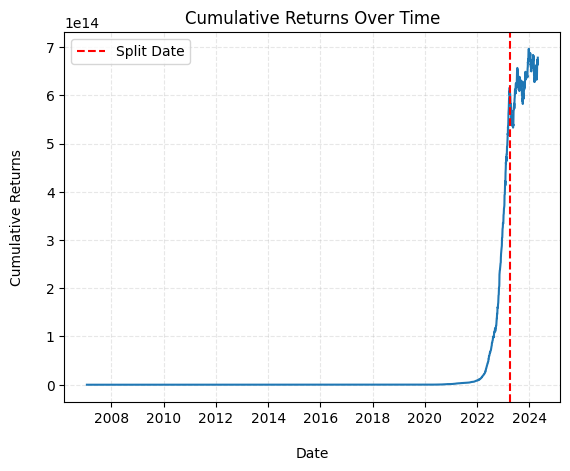

In [12]:
long_classes = [2,3,4]
short_classes = [item for item in all_classes if item not in long_classes]
# Filter data based on the long and short classes
long_condition = df['Predicted_Class'].isin(long_classes)
short_condition = df['Predicted_Class'].isin(short_classes)
df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
# Calculate returns
df['returns'] = df['signal'] * df['Rp']
# Calculate cumulative returns
df['cum_returns'] = (df['returns'] + 1).cumprod()

# Plot the cumulative results
plt.plot(df['Date'],df['cum_returns'])
plt.xlabel('\nDate')
# plt.xticks(df['Date'], rotation=90)
plt.ylabel('Cumulative Returns\n')
plt.title('Cumulative Returns Over Time')
plt.grid(True,alpha=0.3,linestyle='--')
split_date = pd.to_datetime(split_date)
plt.axvline(x=split_date, color='r', linestyle='--', label='Split Date')
plt.legend()
plt.show()